<a href="https://colab.research.google.com/github/arsyiadlani/Sentiment-Analysis/blob/main/reddit_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA RETRIEVING

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/Twitter_Data.csv")
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


##DATA PREPROCESSING

In [ ]:
# Searching unique values of "category" column to determine model classes
df["category"].unique()

array([-1.,  0.,  1., nan])

In [ ]:
# Checking for null values in the dataset
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
# Handling null values in the dataset
df = df[(df["clean_text"].notna()) & (df["category"].notna())]  # Selecting the non-null value only
print(df.isnull().sum())
print(df.shape)

clean_text    0
category      0
dtype: int64
(162969, 2)


In [ ]:
# Determining the algorithm for the neural model
import numpy as np

sample_num = 162969  # Number of samples in the dataset
words_num = []

for sentence in df["clean_text"].values:
  len_words = len(sentence.split())
  words_num.append(len_words)

words_per_sample = np.median(words_num)  # Median value of the number of words in a sample
print(sample_num / words_per_sample)

"""Because the value of total sample number divided by median of the number of words 
in every sample is >1500, we can safely conclude that this particular dataset is 
suitable for NLP analysis using embedding vectors technique.
"""

9053.833333333334


In [ ]:
# Labeling the dataset
df["category"].replace({-1.0:"negative", 0.0:"neutral", 1.0:"positive"})
df

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
...,...,...
162975,why these 456 crores paid neerav modi not reco...,negative
162976,dear rss terrorist payal gawar what about modi...,negative
162977,did you cover her interaction forum where she ...,neutral
162978,there big project came into india modi dream p...,neutral


In [ ]:
# One-hot-encoding the dataset
sentiment_category = pd.get_dummies(df["category"])
added_df = pd.concat([df, sentiment_category], axis=1).drop(columns="category")
added_df = added_df.sample(frac=1).reset_index(drop=True)  # Shuffling the dataset
added_df

,clean_text,negative,neutral,positive
0,alas you people had warned before 2014 would h...,1,0,0
1,all the tainted scams ridden leaders are the d...,0,0,1
2,beg disagree ’ the congress that’ dragging the...,0,0,1
3,why are you even discussing politics then ever...,1,0,0
4,pakistan nothing comparison india but after mo...,0,0,1
...,...,...,...,...
162964,india successfully tests antisatellite weapon ...,0,0,1
162965,shuja got political asylum and not asylum for ...,1,0,0
162966,doesnt matter what says its all about who less...,0,0,1
162967,aaps shri harinder shinh khalsa joined the bjp,0,1,0


In [ ]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = added_df["clean_text"].values
y = added_df.iloc[:, 1:4].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Tokenizing the dataset
tokenizer = Tokenizer(num_words=9000, oov_token="oov")
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding the dataset sequences
padded_train = pad_sequences(train_sequences)
padded_test = pad_sequences(test_sequences)

##MODEL TUNING AND STRUCTURING

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Implementing callback
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if ((logs.get("accuracy") > 0.96) and (logs.get("val_accuracy") > 0.96)):
      print("\nModel training and validation process has reached more than 96% of accuracy!")
      self.model.stop_training = True

callbacks = MyCallback()

# Building and structuring the neural model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=9000, output_dim=16),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()  # Reviewing the neural model architecture

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

# Training the neural model
history = model.fit(padded_train, y_train, validation_data=(padded_test, y_test), 
          epochs=30, callbacks=[callbacks], verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          144000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

##MODEL LOSS AND ACCURACY VISUALIZATION

###LOSS VISUALIZATION

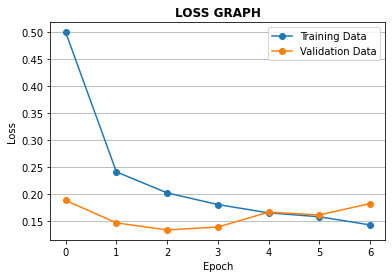

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], marker="o", label="Training Data")
plt.plot(history.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

###ACCURACY VISUALIZATION

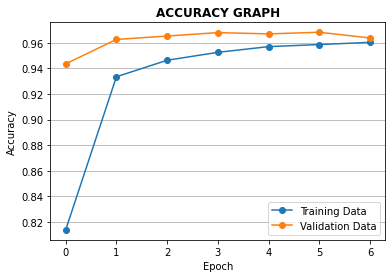

In [ ]:
# Plot training and validation accuracy during learning process
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], marker="o", label="Training Data")
plt.plot(history.history["val_accuracy"], marker="o", label="Validation Data")
plt.title("ACCURACY GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

##REFERENCE

###Dataset source: https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv